In [1]:
!nvidia-smi

Tue Jan 31 22:32:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      On   | 00000000:04:00.0 Off |                  N/A |
| 28%   35C    P8    25W / 250W |      0MiB / 12066MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN V      On   | 00000000:05:00.0 Off |                  N/A |
| 28%   

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
from jax.experimental import ode
import matplotlib.pyplot as plt
from IPython import display
from functools import partial
import haiku as hk
import optax
import itertools

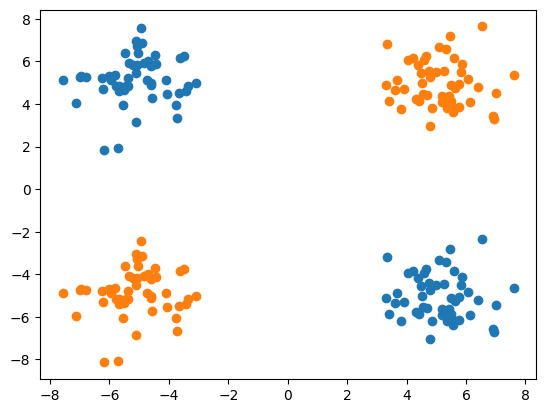

In [110]:
"""
    Generate samples at t=0
"""
def sample_x0(key, batchsize):
    sigma = 1
    key1, key2, key3 = jax.random.split(key, 3)
    x = jax.random.normal(key1, (batchsize//2, 2))*sigma + jnp.array([-5, 5]).reshape(-1, 2)
    y = jax.random.normal(key2, (batchsize//2, 2))*sigma + jnp.array([5, -5]).reshape(-1, 2)
    xy = jnp.concatenate([x,y], axis = 0)
    return jax.random.permutation(key3, xy)

"""
    Generate samples at t=1
"""
def sample_x1(key, batchsize):
    sigma = 1
    key1, key2, key3 = jax.random.split(key, 3)
    x = jax.random.normal(key1, (batchsize//2, 2))*sigma + jnp.array([-5, -5]).reshape(-1, 2)
    y = jax.random.normal(key2, (batchsize//2, 2))*sigma + jnp.array([5, 5]).reshape(-1, 2)
    xy = jnp.concatenate([x,y], axis = 0)
    return jax.random.permutation(key3, xy)

def test_plot_samples(key,batchsize):
    x0 = sample_x0(key,batchsize)
    x1 = sample_x1(key,batchsize)
    plt.scatter(x0[:,0],x0[:,1])
    plt.scatter(x1[:,0],x1[:,1])
    plt.show()
    
test_plot_samples(jax.random.PRNGKey(42),100)


In [111]:
"""
    Generate a haiku Module with MLP
    n : The number of particles
    spatial_dim : The dimensions of the system
    ch : Number of channels = Number of channels in each MLP layer
    num_laryers : Number of layers
    
    Return a haiku module: Input dim: ch, Output dim: 1
"""
def MLP_with_t(n, spatial_dim, ch=384, num_layers=3):
    
    init = hk.initializers.Constant(0)
    middle_layers = num_layers*[ch] # size of Output 

    network = lambda x: hk.Sequential([
        lambda x: hk.nets.MLP(middle_layers)(x),
        lambda x: hk.Linear(n*spatial_dim, init, init)(x) # The output is location of N particles in spatial dims.
    ])(x)

    return network

"""
    Make a hamiltonian which will be used to generate Hamiltonian flow.
    
    Return: (params, haiku apply function)
    The haiku apply function:
        Input : p, q, t
        Output: a number
"""
def make_hamiltonian_net(rng, n, spatial_dim, ch=512, num_layers=2):

    model = MLP_with_t(n, spatial_dim, ch, num_layers)
    def hamiltonian_net(p, q, t):
        input = jnp.concatenate((p, q, t.reshape(1)))
        # input = jnp.concatenate((p, q, jnp.cos(jnp.arange(10)*t))) # Does not work
        return model(input).sum()

    net = hk.without_apply_rng(hk.transform(hamiltonian_net))

    params = net.init(rng, jnp.ones((n*spatial_dim,)), jnp.ones((n*spatial_dim,)), jnp.ones((1,)))
    net_apply = net.apply

    return params, net_apply

In [112]:
'''
continuous transformation in phase space 
d q /d t =   grad_p H 
d p /d t = - grad_q H 
'''
def phasespace_v(params, hamiltonian_net, x, t):
    p, q = jnp.split(x, 2)
    return jnp.concatenate([-jax.grad(hamiltonian_net, argnums=2)(params, p, q, t), 
                             jax.grad(hamiltonian_net, argnums=1)(params, p, q, t)])

"""
    make_loss(hamiltonian_net). Only to design for the input is the hamiltonian net.
    return a loss function.
    Loss function:
        Input : params of loss, x0 batch,  x1 batch, t batch
        Output: loss of params.
"""
def make_loss(potential_net):

    @partial(jax.vmap, in_axes=(None, 0, 0, 0), out_axes=0)
    def _matching(params, x0, x1, t):
        x = t*x1 + (1 - t)*x0
        v = phasespace_v(params, potential_net, x, t)

        return jnp.sum(((x1 - x0) - v)**2)

    def loss_fn(params, x0, x1, t):
        m = _matching(params, x0, x1, t)
        return jnp.mean(m)

    return loss_fn


In [113]:
def train(key, value_and_grad, nepoch, batchsize, params, lr, sample_x0, sample_x1):

    # @jax.jit
    def step(key, i, params, state):
        key, key_x0, key_x1, key_t = jax.random.split(key, 4)
        x0 = sample_x0(key_x0, batchsize)
        x1 = sample_x1(key_x1, batchsize)
        t = jax.random.uniform(key_t, (batchsize, ))
        t = t**2

        value, grad = value_and_grad(params, x0, x1, t)
        
        updates, state = optimizer.update(grad, state)
        params = optax.apply_updates(params, updates)

        return params, key, state, value
    
    optimizer = optax.adam(lr)
    state = optimizer.init(params)

    itercount = itertools.count()
    for epoch in range(1, nepoch+1):
        params, key, state, loss = step(key, next(itercount), params, state)
        if (epoch %100 ==0):
            print (epoch, loss)

    return params

In [114]:
key = jax.random.PRNGKey(42)
params, network = make_hamiltonian_net(key, 1, 1, 512, 4)
loss_fn = make_loss(network)
value_and_grad = jax.value_and_grad(loss_fn)

In [115]:
epochs = 1000
lr = 1e-3
batchsize = 1000
params = train(key, value_and_grad, epochs, batchsize, params, lr, sample_x0, sample_x1)

100 49.06706729686677
200 45.77014783267394
300 46.820219371865484
400 44.341404313490905
500 45.80192859956241
600 44.36858669412042
700 44.490450458355
800 44.453345417527
900 46.781602704357965
1000 44.71518449739679


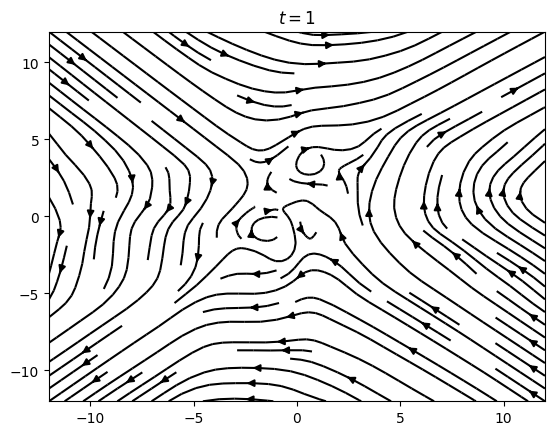

In [116]:
def show_flow(t):
    ymesh, xmesh = np.mgrid[-12:12:21j, -12:12:21j]
    x = np.stack([xmesh, ymesh], axis=-1).reshape(-1, 2)
    v = jax.vmap(phasespace_v,(None, None, 0 , None))(params,network, x , t)
    mag = jnp.linalg.norm(v, axis=-1).reshape(-1, 1)
    v = (v / mag)
    v = v.reshape(21, 21, 2)
    plt.streamplot(xmesh, ymesh, v[:, :, 0], v[:, :, 1], color="black")
    plt.title('$t=%g$'%t)

# Show Flow !
for t in np.linspace(0, 1, 11):
    display.clear_output(wait=True)
    show_flow(t)
    plt.draw()
    plt.pause(0.1)
    

In [117]:
def make_pushfoward(network,params):
    def v(x,t): return phasespace_v(params, network, x, t)

    @partial(jax.vmap, in_axes=(0, None), out_axes=0)
    def forward(x0, int_to_t):
        xt = ode.odeint(lambda x,t: v(x, t),
                 x0,
                 jnp.linspace(0, int_to_t), 
                 rtol=1e-10, atol=1e-10,
                 mxstep=100
                 )
        return xt[-1]
    
    @partial(jax.jit, static_argnums=(1,2))
    def sample_fn(key, batchsize, int_to_t):
        x0 = sample_x0(key, batchsize)
        return forward(x0, int_to_t)
    
    return sample_fn

push_forward = make_pushfoward(network,params)
x0 = sample_x0(key,batchsize)
x1 = sample_x1(key,batchsize)
sample = push_forward(key,batchsize,0.1)

# def show_drive(t):
#     samples = sample_fn(key, params, batchsize) # generated samples
#     plt.scatter(x0[:, 0], x0[:, 1], label='x0')
#     plt.scatter(x1[:, 0], x1[:, 1], label='x1')
#     plt.scatter(samples[:, 0], samples[:, 1], label='samples')

#     # copy from show flow
#     ymesh, xmesh = np.mgrid[-12:12:21j, -12:12:21j]
#     x = np.stack([xmesh, ymesh], axis=-1).reshape(-1, 2)
#     v = jax.vmap(phasespace_v,(None, None, 0 , None))(params,network, x , t)
#     mag = jnp.linalg.norm(v, axis=-1).reshape(-1, 1)
#     v = (v / mag)
#     v = v.reshape(21, 21, 2)
#     plt.streamplot(xmesh, ymesh, v[:, :, 0], v[:, :, 1], color="black")
#     plt.title('$t=%g$'%t)

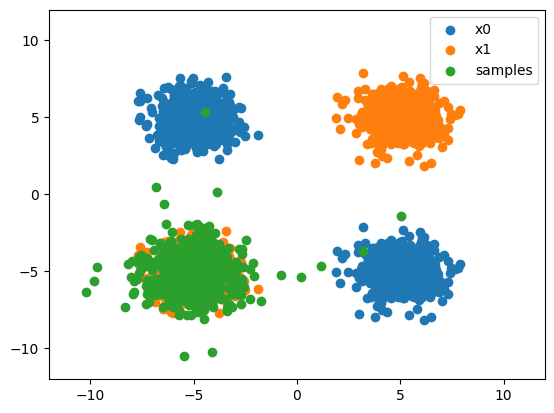

In [118]:
plt.scatter(x0[:, 0], x0[:, 1], label='x0')
plt.scatter(x1[:, 0], x1[:, 1], label='x1')
plt.scatter(samples[:, 0], samples[:, 1], label='samples')
plt.xlim([-12, 12])
plt.ylim([-12, 12]) # Some point out of range? Why? 
plt.legend(loc="upper right")
plt.draw()
# for t in np.linspace(0, 1, 11):
#     display.clear_output(wait=True)
#     show_drive(t)
#     plt.draw()
#     plt.pause(0.1)
    